# ML / DL Prototype 

Time Estimate: 25 - 30 Hours / 50 - 60 Hours (depending on if you decide to build both prototypes)
The goal of this step is to find a machine learning or deep learning approach that works for your problem, and then show that the approach you choose is a viable one. Since the application has not been deployed to production yet, we’ll call it a prototype.

For this step, you’ll build your prototype in a Jupyter notebook. Depending on your problem, you’ll be using a more ‘traditional’ machine learning (ML) technique or a deep learning (DL) technique. Your goal is to come up with a working implementation of your prototype in a Jupyter notebook. This prototype could work on a subset of the data but demonstrates that your approach to solving the problem is a viable one based on the following criteria:
- The data has been reasonably split into training, validation, and test sets.
- You have used the correct metric(s) to evaluate the performance of your
algorithm.
- The performance of your algorithm is ‘good enough’ as determined by your mentor.

### Rubric

- The submission shows that the student understands how to design, implement, and justify a suitable machine learning and/or deep learning approach to a problem.
- The submission demonstrates that the student made thoughtful decisions about validating and testing the approach:
    - The data has been reasonably split into training, validation, and test sets
    - The ML/DL algorithm chosen for the approach makes sense in the context of the problem
    - The student has used the correct metric(s) to evaluate the performance of their algorithm
    - The performance of their algorithm is ‘good enough’ to meet the requirements of the business problem

- Well-documented GitHub repository and code. The Jupyter notebooks for the code provide step-by-step documentation that’s easy to follow. 

# ML Prototype

## Summary
In this section I explore the following questions:

- Q: What is the best classification objective for the call center use case and performance metric? 
- Q: What is the fastest model for prototyping? 
- Q: What is the minimal amount of training data to quickly assess performance?
- Q: What is the source of model confusion?
- Q: What is the effect of using the librosa features mel, mfcc, chroma, vs the precomputed MELD features?

Next I will present the ML prototype as part of a pipeline comprised of several ideas explored previously:
- feature extraction with best determined audio limit    
- oversampling using ADASYN to rectify class imbalance
- feature standardization using QuantileTransformer to correct mel features with right-skewed power-law distributions
- PCA to reduce dimensionality 
- Light Gradient Boosting model
    - optimizing with Bayesian hyperparameter search

In [1]:
from math import ceil, floor
import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline 
try:
    import librosa
except Exception:
    print('librosa unavailable, must be python 3.7 env')
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (silhouette_score, f1_score, plot_confusion_matrix, 
                             plot_precision_recall_curve, precision_score, recall_score)
from sklearn.preprocessing import QuantileTransformer
from skopt import BayesSearchCV
from skopt.callbacks import TimerCallback, DeadlineStopper
from skopt.space import Real, Categorical, Integer
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn import init
from torch import nn
import torch.nn.functional as F
import torch
from tqdm.notebook import tqdm_notebook

librosa unavailable, must be python 3.7 env


Load dataset including raw audio and previously computed MELD features on best audio limit.

In [2]:
df = pd.read_pickle('data/features/df.pkl')

In [3]:
extract_limit = df.extract_limit.values[0]  # previously found good audio limit
sr = df.sr.values[0] # sample rate

# NB cannot use select_dtypes since features are stored under *int* index *names*
X = df[[c for c in df.columns.values if isinstance(c, int)]] #  + ['audio', 'sr']

print('limit ', extract_limit)
print('sr ', sr)
print('X ', X.shape)

limit  110250
sr  22050.0
X  (13700, 160)


## Objective

In previous notebooks I focused on emotion classification, however I began to question the ability to achieve good performance using this objective. Furthermore, for the call center use case of flagging problematic calls quickly, it is acceptable to make a binary judgement regarding the call. Here I will explore 3 possible objectives: 
- emotion classification: neutral, ...
- sentiment classication: neutral, positive, negative
- negativity classification: negative, not-negative, where neutral and positive are mapped to 'not-negative'

In [4]:
df.Sentiment.value_counts() / sum(df.Sentiment.value_counts()) * 100

neutral     46.956204
negative    30.525547
positive    22.518248
Name: Sentiment, dtype: float64

In [5]:
def sentiment_to_negativity(v):
    return 1 if v.lower() == 'negative' else 0

df['negativity'] = df.Sentiment.apply(sentiment_to_negativity)
df[['Sentiment', 'negativity']].sample(10)

,Sentiment,negativity
4822,neutral,0
8346,neutral,0
7574,negative,1
81,neutral,0
8427,neutral,0
9067,positive,0
1237,neutral,0
858,neutral,0
5130,negative,1
5183,neutral,0


In [6]:
df.negativity.value_counts() / df.negativity.value_counts().sum()

0    0.694745
1    0.305255
Name: negativity, dtype: float64

### Baseline Classification Performance

In [7]:
baseline = dict()
labels = ('Emotion', 'Sentiment', 'negativity')
for label in labels:
    max_class = df[label].value_counts().idxmax()
    score = f1_score(df[label], [max_class] * len(df), average='weighted')
    baseline[label] = score
    print(f'{label} always predict "{max_class}" for f1={score:.4f}')

Emotion always predict "neutral" for f1=0.3001
Sentiment always predict "neutral" for f1=0.3001
negativity always predict "0" for f1=0.5696


Now I would to get a reminder of the performance from naive tree-based model...

In [8]:
naive = dict()
for label in labels:
    y = df[label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=0)
    obj = 'binary' if label == 'negativity' else 'multiclass'
    m = lgb.LGBMClassifier(objective=obj, class_weight='balanced', random_state=0, n_jobs=-1)
    m.fit(X_train, y_train)
    score = f1_score(y_test, m.predict(X_test), average='weighted')
    print(label, score)
    naive[label] = score

Emotion 0.3353950103123477
Sentiment 0.39965233182724624
negativity 0.6047747015178847


In [9]:
for label in labels:
    print(label, naive[label] - baseline[label])

Emotion 0.03532123812367971
Sentiment 0.09957855963857826
negativity 0.035166777135027916


Looks like Sentiment can be more easily classified but I will have to check the confusion matrix to see if this corresponds to the neutral/positive classes vs. the negative.

## Prototyping

I want to be able to quickly test ideas. First I will check model training speed of the various tree models I'd like to try.

In [36]:
%%timeit
lgb.LGBMClassifier(objective='multiclass', class_weight='balanced', random_state=0, n_jobs=-1).fit(X, y=df.Emotion)

2.95 s ± 88.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
%%timeit
lgb.LGBMClassifier(objective='multiclass', class_weight='balanced', random_state=0, n_jobs=-1).fit(X, y=df.Sentiment)

1.3 s ± 87.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
%%timeit
lgb.LGBMClassifier(objective='binary', class_weight='balanced', random_state=0, n_jobs=-1).fit(X, y=df.negativity)

446 ms ± 25.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
%%timeit
RandomForestClassifier(class_weight='balanced', random_state=0, n_jobs=-1).fit(X, y=df.Emotion)

2.96 s ± 69.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
%%timeit
RandomForestClassifier(class_weight='balanced', random_state=0, n_jobs=-1).fit(X, y=df.Sentiment)

2.42 s ± 26.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
%%timeit
RandomForestClassifier(class_weight='balanced', random_state=0, n_jobs=-1).fit(X, y=df.negativity)

2.09 s ± 119 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Results of speed test:
Objective-wise: Emotion > Sentiment > negativity. Model-wise, RF > LGBM

So I will focus on the LGBM on Sentiment and negativity labels.

### Subsampling

Can I reduce the training size and still get comparable performance in a short amount of time?
Specifically, I will look at the effect of train size on the std of cross-val scores. Also, the effect of train size on test set perf.

In [59]:
def get_model(binary: bool=False):
    obj = 'binary' if binary else 'multiclass'
    return lgb.LGBMClassifier(objective=obj, class_weight='balanced', random_state=0, n_jobs=-1)


def experiment_subsampling(sizes, X, y, binary=False):
    """For given range of training sizes, plots CV scores and test scores."""
    results = []
    for size in tqdm_notebook(sizes):
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=size, stratify=y, random_state=0)
        scores = cross_val_score(get_model(binary), X_train, y_train, scoring='f1_weighted', cv=5, n_jobs=-1)

        model = get_model(binary).fit(X_train, y_train)
        skill = f1_score(y_test, model.predict(X_test), average='weighted')
        results.append((size, np.mean(scores), np.std(scores), scores, skill))

    res_df = pd.DataFrame(results, columns=['size', 'mean-score', 'std', 'scores', 'test'])
    res_df.plot(x='size', y='mean-score', yerr='std');
    res_df.plot(x='size', y='test');

  0%|          | 0/10 [00:00<?, ?it/s]

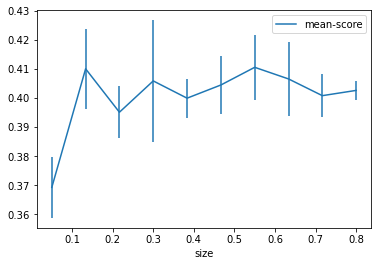

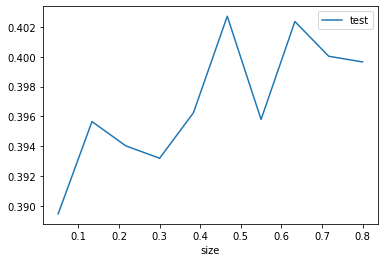

In [42]:
experiment_subsampling(np.linspace(0.05, 0.8, 10), X, y=df.Sentiment)

  0%|          | 0/10 [00:00<?, ?it/s]

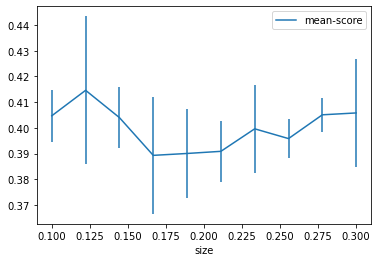

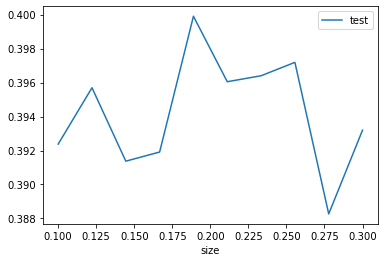

In [43]:
experiment_subsampling(np.linspace(0.1, 0.3, 10), X, y=df.Sentiment)

For Sentiment classification the CV variance and test score seems good for even with 10% of the data. The test score is better for more data is greater, but it's only about 0.01 F1.

  0%|          | 0/10 [00:00<?, ?it/s]

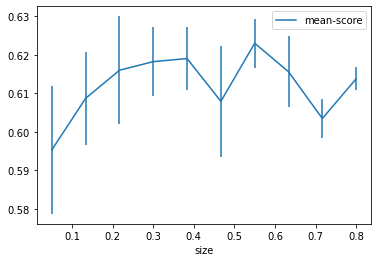

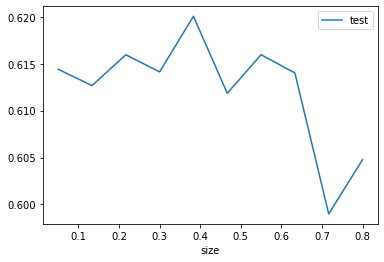

In [47]:
experiment_subsampling(np.linspace(0.05, 0.8, 10), X, y=df.negativity, binary=True)

  0%|          | 0/10 [00:00<?, ?it/s]

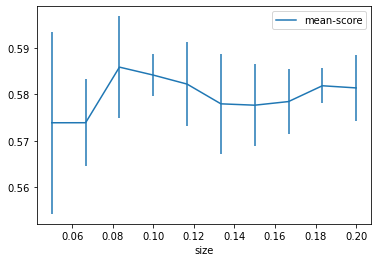

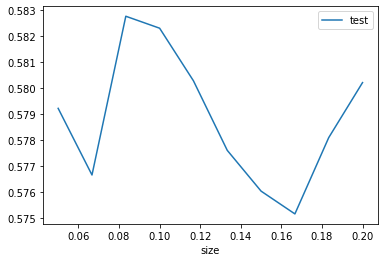

In [65]:
experiment_subsampling(np.linspace(0.05, 0.2, 10), X, y=df.negativity, binary=True)

About 10% of the data can also be sufficient in assessing negativity.

## Model Confusion

Let's take a close look at the errors in classification using the confusion matrix, precision, recall, and ROC AUC metrics.

Here I favor ROC AUC over PR AUC since the classes are not highly imbalanced (cf https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/)

### Sentiment

In [62]:
sent_model = get_model()
y = df.Sentiment
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=0)
sent_model.fit(X_train, y_train)
y_pred = sent_model.predict(X_test)

In [63]:
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f'prec={prec:.4f} rec={rec:.4f}'

'prec=0.3956 rec=0.4058'

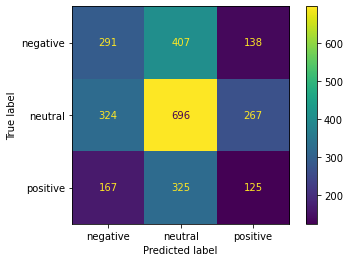

In [64]:
plot_confusion_matrix(sent_model, X_test, y_test);

Precision/recall are about the same. In the confusion matrix we see negative labels are getting confusing mainly as 'neutral' but also with positive.

Focusing on the negative class, there were 291 correct predictions, 545 false negatives, and 491 false positives

### Negativity 

In [66]:
neg_model = get_model(binary=True)
y = df.negativity
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=0)
neg_model.fit(X_train, y_train)
y_pred = neg_model.predict(X_test)

In [67]:
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f'prec={prec:.4f} rec={rec:.4f}'

'prec=0.6052 rec=0.6044'

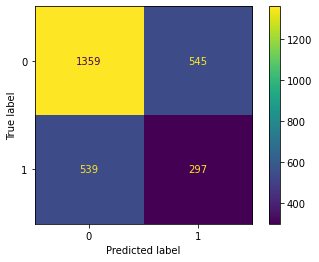

In [68]:
plot_confusion_matrix(neg_model, X_test, y_test);

For negativity the error types occur in equal number but the positive class is predicted much less accurately than the negative class.

There were slightly more true positives at 297 and about the same false negatives and false positives.

For educational purpose, here's the ROC curve for the classifier as well:

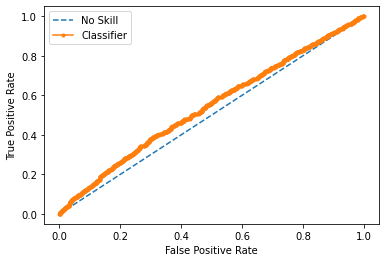

In [76]:
from sklearn.metrics import roc_curve, roc_auc_score

yhat = neg_model.predict_proba(X_test)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
fpr, tpr, _ = roc_curve(y_test, pos_probs)

plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show();

In [77]:
roc_auc_score(y_test, pos_probs)

0.544000165855816

## Librosa Feature vs. MELD features 

In the data wrangling notebook, I explored using melspectrogram, mfcc, and chroma features using the librosa library. The MELD data set provides its own precomptuted features described as:

audio_embeddings_feature_selection_emotion.pkl,audio_embeddings_feature_selection_sentiment.pkl - It consists of 1611/1422 dimensional audio feature vectors of each utterance trained for emotion/sentiment classification. These features are originally extracted from openSMILE and then followed by L2-based feature selection using SVM. It is a list comprising of 3 dictionaries for train, val and the test set with each dictionary indexed in the format dia_utt, where dia is the dialogue id and utt is the utterance id. For eg. train_audio_emb['0_0'].shape = (1611, ) or (1422, )

Here I will satisfy my curiosity as to whether the librosa features stack up to the MELD openSMILE features. 

In [79]:
import pickle

path = 'data/meld_features/audio_embeddings_feature_selection_{}.pkl'
all_features = []
for label in ('emotion', 'sentiment'):  
    f = path.format(label)
    datasets = pickle.load(open(f, 'rb'))
    for ds in datasets:
        tmp = pd.DataFrame(data=ds.items(), columns=['dia_utt', label + '_features'])
        all_features.append(tmp)
        print(label, ' size ', len(ds))

emotion  size  9989
emotion  size  1109
emotion  size  2610
sentiment  size  9989
sentiment  size  1109
sentiment  size  2610


In [80]:
for d in all_features:
    print(d.columns.values)

['dia_utt' 'emotion_features']
['dia_utt' 'emotion_features']
['dia_utt' 'emotion_features']
['dia_utt' 'sentiment_features']
['dia_utt' 'sentiment_features']
['dia_utt' 'sentiment_features']


In [81]:
from functools import reduce

train_df = pd.read_csv('data/train_labels.csv')
dev_df = pd.read_csv('data/dev_labels.csv')
test_df = pd.read_csv('data/test_labels.csv')
labels_dfs = (train_df, dev_df, test_df)

emo_features = all_features[:3]
sent_features = all_features[3:]

joins = []
for labels, emo_feats, sent_feats in zip(labels_dfs, emo_features, sent_features):
    cols = ['Dialogue_ID', 'Utterance_ID']
    labels['dia_utt'] = labels[cols].apply(lambda r: '_'.join(r.values.astype(str)), axis=1)
    
    # of the 6 feature sets we have join 1 here, later I will concat them into 1
    ds_joined = reduce(lambda a, b: pd.merge(a, b, on='dia_utt'), [labels, emo_feats, sent_feats])
    joins.append(ds_joined)

emb_df = pd.concat(joins)
emb_df.shape

(13708, 14)

In [82]:
emb_df.head(1)

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,dia_utt,emotion_features,sentiment_features
0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731",0_0,"[0.579978439650127, 0.9748008896749043, 0.1564...","[0.579978439650127, 0.9748008896749043, 0.1564..."


OK, so now I have loaded all the precomputed MELD features into a single DF.

In [83]:
from sklearn.preprocessing import LabelEncoder

y_emo = LabelEncoder().fit_transform(emb_df['Emotion'])
y_sent = LabelEncoder().fit_transform(emb_df['Sentiment'])
y_emo.shape, y_sent.shape

((13708,), (13708,))

In [84]:
X_emo = np.array([f for f in emb_df['emotion_features'].values])
X_sent = np.array([f for f in emb_df['sentiment_features'].values])
X_emo.shape, X_sent.shape

((13708, 1611), (13708, 1422))

In [85]:
from sklearn.metrics import silhouette_score

emo_sil = silhouette_score(X_emo, y_emo)
sent_sil = silhouette_score(X_sent, y_sent)

In [86]:
print('emo sil ', emo_sil, ' sent sil ', sent_sil)

emo sil  -0.01453310196481637  sent sil  -0.0018931991703444366


So these precomputed features have slightly better sil scores than the librosa features I computed in the earlier data exploration on emotion:
- mel -0.04264662
- mfcc -0.041319244
- chroma -0.030214868

I've never computed sentiment silhouette score before so I don't have a comparison with the librosa features.
Also, instead of 160 features as with librosa there are about 10X the number of precomputed features. Given this large number of features, I will try PCA to determine if they can be reduced.

In [87]:
def run_pca(X, y, c_s):
    scores = []
    for c in tqdm_notebook(c_s):
        pca = PCA(n_components=c)
        reduced = pca.fit_transform(X)
        scores.append(silhouette_score(reduced, y))   
    return scores

  0%|          | 0/15 [00:00<?, ?it/s]

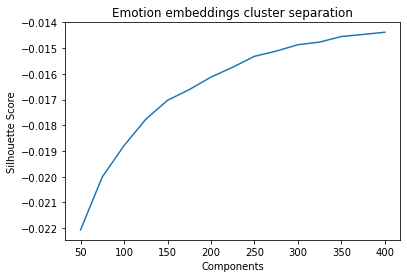

In [85]:
c_s = list(range(50, 411, 25))  # 1611
scores = run_pca(X_emo, y_emo, c_s)
plt.plot(c_s, scores)
plt.title('Emotion embeddings cluster separation')
plt.xlabel('Components')
plt.ylabel('Silhouette Score')
plt.show();

  0%|          | 0/15 [00:00<?, ?it/s]

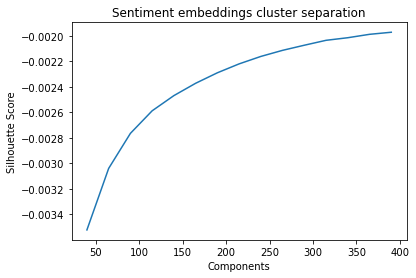

In [86]:
c_s = list(range(40, 411, 25))  # 1422
scores = run_pca(X_sent, y_sent, c_s)
plt.plot(c_s, scores)
plt.title('Sentiment embeddings cluster separation')
plt.xlabel('Components')
plt.ylabel('Silhouette Score')
plt.show();

The sentiment embeddings do better than the emotion embeddings. While there are way more features than 
librosa mel, mfcc, and chroma I can use PCA and reduce it to say 50 features without much drop in cluster separation.

I am curious to know how the sentiment embeddings perform with a model for the sentiment classification as compared to the scores from the librosa features found earlier.

In [89]:
sent_emb_model = get_model()
X_train, X_test, y_train, y_test = train_test_split(X_sent, y_sent, train_size=0.8, stratify=y_sent, random_state=0)
sent_emb_model.fit(X_train, y_train)
y_pred = sent_emb_model.predict(X_test)

In [90]:
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f'prec={prec:.4f} rec={rec:.4f}'

'prec=0.4970 rec=0.5109'

With the librosa features I got: 'prec=0.3956 rec=0.4058' which is about 0.1 higher in F1 score.

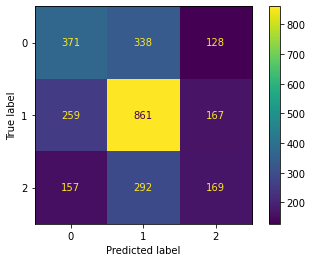

In [91]:
plot_confusion_matrix(sent_emb_model, X_test, y_test);

While 'better' in F1, the drawbacks of the MELD embeddings are:
- not easily reproducible 
- can't use partial / prefix audio
- larger number of features -> longer training time

But they do suggest that fine tuning the feature extraction could provide some small gains in performance. 

## Librosa Extraction Tuning

The following extraction hyperparameters can be tuned: 

mfcc 
- n_mfcc in [13, 26] 
- dct_type in [1, 2, 3]

chroma_stft
- n_fft=220 for .01 s and 2205 for .1 s, hop length can be 1/2 or 1/4 the window size
- hop_length
- m_chroma=12
- center=T/F

melspectrogram 
- n_fft=220 for .01 s and 2205 for .1 s, hop length can be 1/2 or 1/4 the window size
- hop_length


In [4]:
def extract_mfcc_mean(audio, sr, **kwargs):
    return np.mean(librosa.feature.mfcc(y=audio, sr=sr, **kwargs).T, axis=0)


def extract_chroma_mean(audio, sr, **kwargs):
    stft = np.abs(librosa.stft(audio))
    return np.mean(librosa.feature.chroma_stft(S=stft, sr=sr, **kwargs).T, axis=0)


def extract_mel_mean(audio, sr, **kwargs):
    return np.mean(librosa.feature.melspectrogram(y=audio, sr=sr, **kwargs).T, axis=0)
     

In [17]:
def run_extract(df, lim, func, **kwargs):
    X = []
    for i, r in df.iterrows():
        audio = r.audio if lim is None else r.audio[:lim]
        X.append(func(audio, r.sr, **kwargs))
    
    return np.array(X)

In [18]:
# test MFCC hyperparams
xs = list(range(10, 30, 2))
scores = list()
for n_mfcc in xs:   
    feats = run_extract(X_train, extract_limit, extract_mfcc, n_mfcc=n_mfcc)
    scores.append(silhouette_score(feats, y_train))

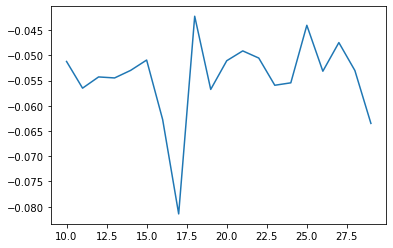

In [10]:
plt.plot(xs, scores);

Disregarding some weird transients, I do not see a strong reason to change the number of MFCC coeffincients from the typical default. 

In [28]:
# test chroma hyperparams
xs = list(range(2, 14))
scores = list()
for n_chroma in xs:  
    feats = run_extract(X_train, extract_limit, extract_chroma, n_chroma=n_chroma)
    scores.append(silhouette_score(feats, y_train))

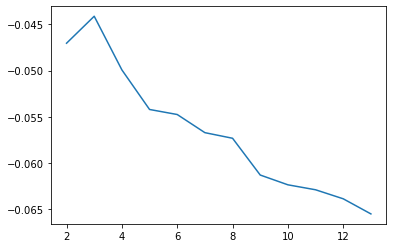

In [29]:
plt.plot(xs, scores);

Interestingly, decreasing the number of chroma appears to improve the class separation a small amount.

## ML Prototype

Pipeline
- oversampling using ADASYN
- feature standardization using Quantile Transformer
- PCA (search components)
- LGBM
    - thorough hyperparameter search with skoptimize



In [28]:
y = df.negativity

Since I changed several things since I last ran PCA, here I will run a simple search again on the number of components.

In [29]:
pipe = Pipeline([
    ('oversample', ADASYN(random_state=0, n_jobs=-1)), 
    ('standardize', QuantileTransformer(output_distribution='normal', random_state=0)),
    ('decomposition', PCA(random_state=0)),
    ('estimator', lgb.LGBMClassifier(objective='binary', class_weight='balanced', random_state=0, n_jobs=-1)),
])
params = {
    'decomposition__n_components': list(range(10, 60)) 
}
search = GridSearchCV(pipe, params, scoring='f1_weighted', cv=5, n_jobs=-1) 

search.fit(X, y)

search.best_params_

{'decomposition__n_components': 51}

In [40]:
def grid_search_plot(search, x, hue=None, col=None):
    result_df = pd.DataFrame.from_dict(search.cv_results_, orient='columns')
    grid = sns.relplot(data=result_df,
                kind='line',
                x='param_' + x,
                y='mean_test_score',
                hue='param_' + hue if hue else None, 
                col='param_' + col if col else None)
    grid.fig.set_size_inches(15, 10)


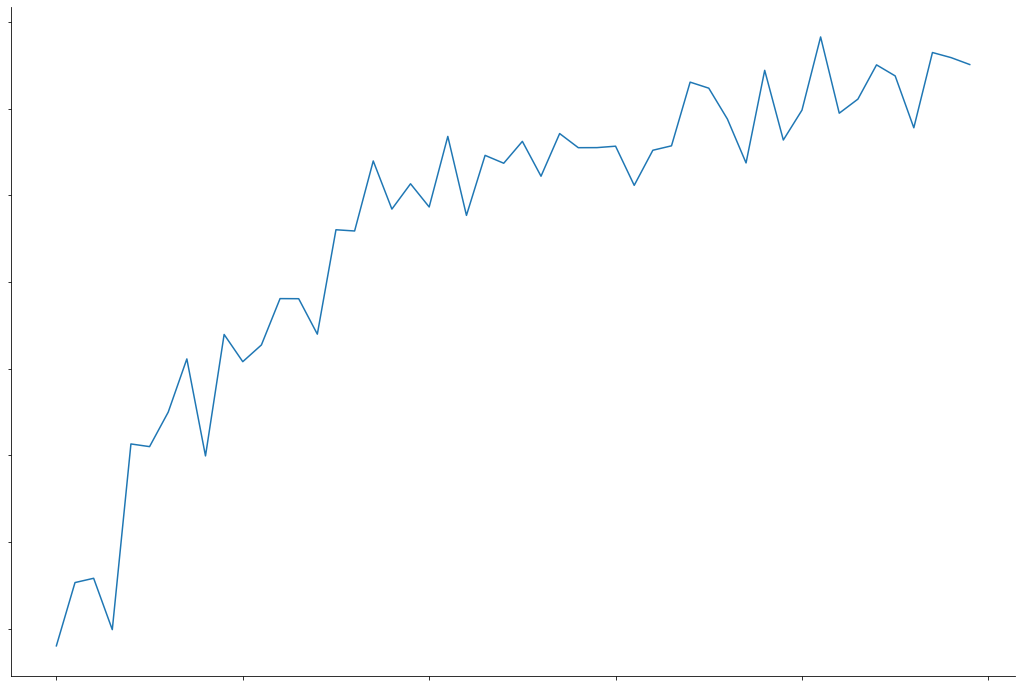

In [41]:
grid_search_plot(search, 'decomposition__n_components');

Looks like 50 components is a good tradeoff between components and score. 

Next I will tune the LGBMClassifier using Bayesian Optimization. Now, since this isn't a simple grid search, I will reduce the training data to a smaller amount as suggested by the earlier experiments.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, stratify=y, random_state=0)

In [11]:
n_components = 50
pipe = Pipeline([
    ('oversample', ADASYN(random_state=0, n_jobs=-1)), 
    ('standardize', QuantileTransformer(output_distribution='normal', random_state=0)),
    ('decomposition', PCA(random_state=0, n_components=n_components)),
    ('model', lgb.LGBMClassifier(objective='binary', class_weight='balanced', random_state=0, n_jobs=-1)),
])

# https://lightgbm.readthedocs.io/en/v3.2.1/pythonapi/lightgbm.LGBMClassifier.html
search_spaces = {
        'model__boosting_type': Categorical(['gbdt', 'dart', 'goss']),               # def=gbdt
        'model__num_leaves': Integer(10, 100),                                       # def=31
        'model__max_depth': Integer(1, 20),                                          # def=-1 no limit
        'model__learning_rate': Real(low=0.001, high=0.5, prior='log-uniform'),      # def=0.1
        'model__n_estimators': Integer(low=50, high=500),                            # def=100    
        'model__min_split_gain': Real(0.0, 1.0),                                     # def=0
        'model__min_child_weight': Real(low=0.00001, high=0.1, prior='log-uniform'), # def=1e-3
        'model__min_child_samples': Integer(10, 30),                                 # def=20
        'model__reg_alpha': Integer(0, 100),                                         # def=0
        'model__reg_lambda': Integer(0, 100),                                        # def=0
        
#         'model__subsample': [1.0],
#         'model__subsample_freq': [0],
#         'model__colsample_bytree': [1],
    }

In [13]:
%%time

# number of parameter settings that are sampled, trades off runtime vs solution quality
n_iter = 10

# time-based stopping criterion
budget_minutes = 120

cbs = [TimerCallback(), DeadlineStopper(60 * budget_minutes)]
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=search_spaces,
    n_iter=n_iter,
    scoring='f1_weighted',
    n_jobs=-1,
    n_points=1,  # number of parameter settings to sample in parallel
    refit=True,  # after opt, refits on entire dataset, so predictions can be made
    verbose=0,
    cv=3
)

opt = opt.fit(X_train, y_train, callback=cbs)

CPU times: user 14 s, sys: 203 ms, total: 14.2 s
Wall time: 21.5 s


Looks like it takes about 2.15s per iteration

In [43]:
f'cv={opt.best_score_:.4f}'

'cv=0.3115'

In [44]:
opt.best_params_

OrderedDict([('model__boosting_type', 'dart'),
             ('model__learning_rate', 0.04020229609548579),
             ('model__max_depth', 13),
             ('model__min_child_samples', 29),
             ('model__min_child_weight', 0.00010600217702290037),
             ('model__min_split_gain', 0.14370387930901055),
             ('model__n_estimators', 369),
             ('model__num_leaves', 51)])

In [95]:
# TODO plot the various search spaces to get a sense of the better parameters

## DL Prototype

Summary: 
1. CNN on melspectrogram followed by Linear Classifier
- following ideas from: https://towardsdatascience.com/audio-deep-learning-made-simple-part-1-state-of-the-art-techniques-da1d3dff2504
2. Create sequence of features and use LSTM

Mel Spectrograms
- regular spectrogram: frequency vs. time
- mel spectrogram: mel scale vs time, colors/intensity of values on decibel scale not amplitude

In [6]:
windows = ceil(extract_limit / 512)
windows

216

In [8]:
X_mfcc = []
for i, r in tqdm_notebook(X.iterrows(), total=X.shape[0]):
    mfcc = librosa.feature.mfcc(y=r.audio[:extract_limit], sr=r.sr)
    # pad the tail of shorter samples with 0s
    mfcc_pad = librosa.util.fix_length(mfcc, size=windows)
    X_mfcc.append(mfcc_pad)

X_mfcc = np.array(X_mfcc)
X_mfcc.shape

  0%|          | 0/13700 [00:00<?, ?it/s]

(13700, 20, 216)

In [106]:
# TODO: 
# - randomly time shift signal

# n_mels=64, n_fft=1024, hop_length

# ----------------------------
# Shifts the signal to the left or right by some percent. Values at the end
# are 'wrapped around' to the start of the transformed signal.
# ----------------------------
def time_shift(aud, shift_limit):
    sig, sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)


# Frequency mask — randomly mask out a range of consecutive frequencies by adding horizontal bars on the spectrogram.
# Time mask — similar to frequency masks, except that we randomly block out ranges of time from the spectrogram by using vertical bars.
    

    
# ----------------------------
# Augment the Spectrogram by masking out some sections of it in both the frequency
# dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
# overfitting and to help the model generalise better. The masked sections are
# replaced with the mean value.
# ----------------------------
def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
        aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
        aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec

In [10]:

class MeldDS(Dataset):
    def __init__(self, X):
        self.X = X
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i]
    
ds = MeldDS(X_mfcc)

In [11]:
lengths = [floor(len(ds) * 0.9), ceil(len(ds) * 0.1)]
train_ds, test_ds = random_split(ds, lengths)

batch_size = 32  # 64, 128
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [125]:
# input: (batch_size, num_channels, mfcc bands, timesteps)
class AudioClassifier (nn.Module):
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm and using Kaiming init
        
        kaiming_a = 0.1
        
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=kaiming_a)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=kaiming_a)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Second Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=kaiming_a)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Second Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=kaiming_a)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=10)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
        
    def _get_conv_block(fan_in: int, fan_out: int, kernel_size, stride, padding, kaiming_a=0.1) -> list:
        conv2d = nn.Conv2d(fan_in, fan_out, kernel_size=kernel_size, stride=stride, padding=padding)
        relu = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(fan_out)
        init.kaiming_normal_(conv2d.weight, a=kaiming_a)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]
        
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        return self.lin(x)


In [127]:
model = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = model.to(device)
next(model.parameters()).device

device(type='cpu')